In [114]:
from PIL import Image
import numpy as np
import os
import pickle
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [113]:
!pip install seaborn

     -------------------------------------- 293.3/293.3 kB 4.5 MB/s eta 0:00:00


# (Done) Exploration with resizing images

In [15]:
synthia_image_path = "D:\zsh\graduation\graduation_dataset\RAND_CITYSCAPES\RGB"
label_path = "D:\zsh\graduation\graduation_dataset\RAND_CITYSCAPES\GT\COLOR"

In [16]:
image = Image.open(synthia_image_path+"\\"+'0000000.png')
label = Image.open(label_path+"\\"+'0000000.png')

In [19]:
print(label)

<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1280x760 at 0x25878EAEF40>


In [21]:
label_arr = np.array(label)

In [22]:
label_arr.shape

(760, 1280, 4)

In [23]:
# example image
new_image = image.resize((256, 256))
new_image.save('image_256.jpg')

new_label = label.resize((256, 256))
new_label = new_label.convert('RGB')
new_label.save('label_256.jpg')

print(image.size) # Output: (1920, 1280)
print(new_image.size) # Output: (400, 400)

(1280, 760)
(256, 256)


# (Done) A function that resize the images and put it to a new folder

In [29]:
synthia_image_path = "D:\zsh\graduation\graduation_dataset\RAND_CITYSCAPES\RGB"
label_path = "D:\zsh\graduation\graduation_dataset\RAND_CITYSCAPES\GT\COLOR"

resize_image_path = "D:\zsh\graduation\graduation_dataset\SYNTHIA_256\image"
resize_label_path = "D:\zsh\graduation\graduation_dataset\SYNTHIA_256\label-rgb"

In [31]:
def resize_images(source_folder,target_folder):
    count= 0
    for filename in os.listdir(source_folder):
        if count>10:
            break
        f = os.path.join(source_folder, filename)
        image = Image.open(f)
        if image.format == "RGBA":
            image = image.convert('RGB')
            
        new_image = image.resize((256, 256))
        new_image.save(os.path.join(target_folder, filename))
        count = count+1

In [32]:
resize_images(synthia_image_path,resize_image_path)

In [33]:
resize_images(label_path,resize_label_path)

# Embedding for the input （pca and tsne）

In [49]:
# Cityscapes
# import the pickle 
pickle_file = "D:\zsh\graduation\graduation_dataset\\5_classes_preprocessed\\validation_images.pkl"
with open(pickle_file, 'rb') as f:
    cityscapes_images = pickle.load(f)
# randomly select images 100 out of the 500
cityscapes_100 = random.choices(cityscapes_images, k=100)
cityscapes_100 = np.array(cityscapes_100)

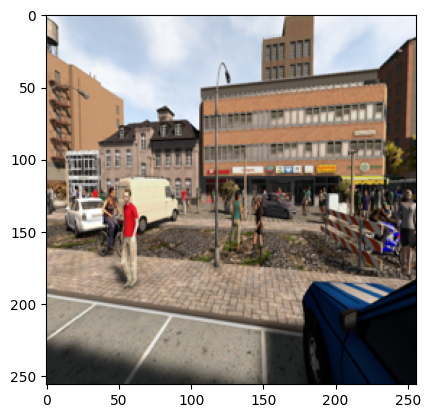

In [63]:
# synthia

synthia_100 = []

synthia_names = os.listdir(resize_image_path)
# randomly select 100 images to load in to numpy array
synthia_names_100 = random.choices(synthia_names, k=100)
for name in synthia_names_100:
    image = Image.open(resize_image_path+"\\"+name).convert("RGB")
    synthia_100.append(np.array(image))

synthia_100 = np.array(synthia_100)

Put the images from two dataset into the same dataframe

In [76]:
combined = np.concatenate((cityscapes_100,synthia_100),axis=0)
combined = np.reshape(combined,(len(combined), 256*256*3))

In [78]:
combined.shape

(200, 196608)

In [79]:
pca = PCA(n_components=2)
pca_embedding = pca.fit_transform(combined)

df_pca = pd.DataFrame(pca_embedding,columns=["pca_1","pca_2"])

In [119]:
pca_50 = PCA(n_components=50)
pca_embedding = pca_50.fit_transform(combined)

tsne = TSNE()
tsne_embedding = tsne.fit_transform(pca_embedding)

df_tsne = pd.DataFrame(tsne_embedding,columns=["tsne_1","tsne_2"])
df_tsne.head()

,tsne_1,tsne_2
0,-4.180974,-2.958743
1,2.140900,3.692464
2,-5.841109,4.012944
3,-1.965212,-2.556649
4,-4.181027,-2.958605


Then generate embedding (PCA, t-SNE(initialized with PCA))

the columns of result df ["pca_1","pca_2","tsne_1","tsne_2"]

In [120]:
df = pd.concat([df_pca, df_tsne], axis=1)
df["dataset"] =np.nan

In [121]:
df["dataset"].iloc[:100] = "Cityscapes"
df["dataset"].iloc[100:] = "Synthia"

C:\Users\Alex\AppData\Local\Temp\ipykernel_22364\835237747.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["dataset"].iloc[:100] = "Cityscapes"


In [122]:
df.head()

,pca_1,pca_2,tsne_1,tsne_2,dataset
0,-2672.427765,-1310.302161,-4.180974,-2.958743,Cityscapes
1,8273.654498,-2289.503758,2.140900,3.692464,Cityscapes
2,1480.098121,4795.353684,-5.841109,4.012944,Cityscapes
3,-6355.224590,2469.303634,-1.965212,-2.556649,Cityscapes
4,-2672.427765,-1310.302161,-4.181027,-2.958605,Cityscapes


<AxesSubplot:xlabel='tsne_1', ylabel='tsne_2'>

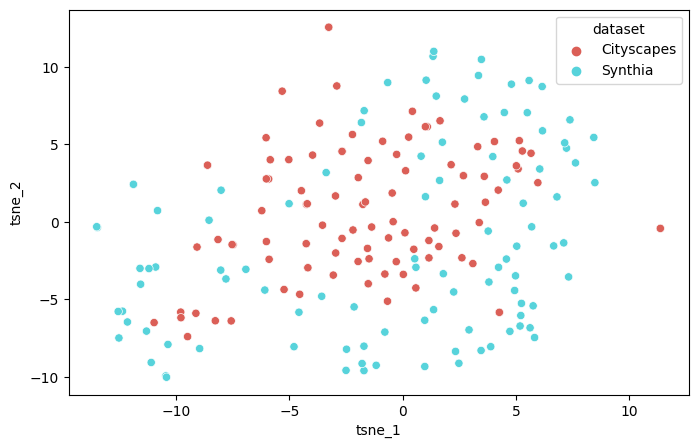

In [123]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne_1", y="tsne_2",
    hue="dataset", # see if this need to be changed
    palette=sns.color_palette("hls", 2), # palette corresponds to hue
    data=df # df_tsne_1 or df_tsne_2
)

In [124]:
df.to_csv("input_df_v3.csv",index=False)

In [ ]:
df_ori_embedding["pca_2"].min()

# Subset: transform the label to class number, and save